Let's try to run a tabular model with just pytorch -- having alot of issues injecting quantile regression into a fastai for some reason

In [1]:
from fastai.tabular.all import *
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
#next two lines needed to use pytorch object vs fastai
from torch.utils.data import Dataset as torch_ds 
from torch.utils.data import DataLoader as torch_dl
from torch.utils.data import Subset as torch_subset
%matplotlib inline

In [2]:
path = Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic')
Path.BASE_PATH = path
path.ls()

(#6) [Path('test.csv'),Path('train'),Path('train.csv'),Path('test'),Path('osic-pulmonary-fibrosis-progression.zip'),Path('sample_submission.csv')]

In [105]:
train_df = pd.read_csv(path/'train.csv')
sample_sub = pd.read_csv(path/'sample_submission.csv')
test_df = pd.read_csv(path/'test.csv')

In [4]:
splits = RandomSplitter(valid_pct=0.1)(range_of(train_df))
splits

((#1395) [6,356,223,1230,504,542,1250,65,1288,434...],
 (#154) [477,351,769,1156,372,587,129,914,1146,238...])

In [5]:
test_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [6]:
train_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [7]:
to = TabularPandas(train_df, procs=[Categorify, Normalize],
                  cat_names = ['Patient','Sex', 'SmokingStatus'],
                  cont_names = ['Weeks', 'Age', 'Percent'],
                  y_names = 'FVC',
                  splits=splits)

In [8]:
dls = to.dataloaders(bs=12)

In [9]:
dls.show_batch()

,Patient,Sex,SmokingStatus,Weeks,Age,Percent,FVC
0,ID00344637202287684217717,Male,Never smoked,-5.303731e-07,58.0,53.959466,2066.0
1,ID00207637202252526380974,Male,Ex-smoker,4.700000e+01,67.0,77.377014,2806.0
2,ID00232637202260377586117,Female,Never smoked,1.100000e+01,74.0,119.542871,1977.0
3,ID00102637202206574119190,Male,Ex-smoker,5.000001e+00,60.0,67.487633,2510.0
4,ID00235637202261451839085,Male,Ex-smoker,5.900000e+01,67.0,55.526508,2124.0
5,ID00025637202179541264076,Male,Ex-smoker,3.800000e+01,65.0,71.439460,2811.0
6,ID00131637202220424084844,Male,Never smoked,6.400000e+01,61.0,71.163002,3407.0
7,ID00183637202241995351650,Male,Ex-smoker,7.700000e+01,71.0,68.247368,2461.0
8,ID00305637202281772703145,Male,Ex-smoker,1.600000e+01,62.0,73.630501,2785.0
9,ID00225637202259339837603,Female,Never smoked,1.900000e+01,77.0,50.493797,997.0


In [10]:
learn = tabular_learner(dls, metrics=mse)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mse,time
0,7861062.000000,8408145.000000,8408145.000000,00:00
1,7559108.500000,7418210.000000,7418210.000000,00:00
2,4648562.500000,2973756.500000,2973756.500000,00:00
3,1959488.375000,1036680.437500,1036680.437500,00:00
4,1024972.812500,591475.312500,591475.312500,00:00
5,715118.750000,327710.218750,327710.218750,00:00
6,730560.937500,363847.562500,363847.562500,00:00
7,689907.312500,338433.218750,338433.218750,00:00
8,576534.125000,313940.187500,313940.187500,00:00
9,550346.875000,247664.281250,247664.281250,00:00


In [11]:
learn.loss_func

FlattenedLoss of MSELoss()

In [12]:
learn.show_results()

,Patient,Sex,SmokingStatus,Weeks,Age,Percent,FVC,FVC_pred
0,115.0,1.0,3.0,1.825305,-0.745994,0.025533,1965.0,1797.693237
1,124.0,2.0,2.0,-1.035560,-1.315284,-0.768120,2099.0,2404.458008
2,104.0,2.0,2.0,0.091447,-0.034382,-1.192520,2061.0,2405.657227
3,60.0,2.0,3.0,2.995658,-0.888316,-0.532624,3208.0,3042.732666
4,84.0,2.0,2.0,1.478533,-0.319027,0.627552,3856.0,3495.457520
5,104.0,2.0,2.0,0.351526,-0.034382,-1.086071,2142.0,2424.401367
6,130.0,1.0,2.0,-0.688789,0.677230,1.104334,1919.0,525.385803
7,134.0,2.0,2.0,0.048101,1.388842,-0.072661,1818.0,945.775452
8,109.0,2.0,2.0,1.911997,-1.599929,-0.859416,2139.0,2542.041992


In [13]:
learn.fit_one_cycle(20, lr=1e-1)

epoch,train_loss,valid_loss,mse,time
0,608448.312500,281585.968750,281585.968750,00:00
1,561156.187500,321681.468750,321681.468750,00:00
2,631933.312500,240129.921875,240129.921875,00:00
3,574734.687500,220511.796875,220511.796875,00:00
4,475528.812500,185868.687500,185868.687500,00:00
5,495907.750000,225740.187500,225740.187500,00:00
6,394654.656250,159552.500000,159552.500000,00:00
7,361444.281250,189942.390625,189942.390625,00:00
8,391534.531250,126350.289062,126350.289062,00:00
9,304362.750000,148309.765625,148309.765625,00:00


In [14]:
learn.show_results()

,Patient,Sex,SmokingStatus,Weeks,Age,Percent,FVC,FVC_pred
0,20.0,1.0,3.0,-0.905521,0.392585,-0.829156,1399.0,1296.232544
1,55.0,2.0,2.0,0.004754,1.531165,-1.079640,2245.0,2215.248779
2,96.0,2.0,2.0,-0.992214,0.392585,-0.866682,2540.0,2489.915283
3,157.0,2.0,3.0,0.048101,-1.599929,-0.157771,3190.0,3213.925049
4,99.0,1.0,2.0,-0.558750,-1.315284,0.599473,1972.0,1731.568115
5,159.0,1.0,3.0,1.348494,-0.461349,1.666310,3121.0,2643.836670
6,131.0,2.0,2.0,0.134793,-0.461349,-1.073538,2325.0,1979.228149
7,84.0,2.0,2.0,1.478533,-0.319027,0.627552,3856.0,3788.024902
8,80.0,2.0,2.0,0.221486,-2.169218,-0.648083,3009.0,3040.931396


The predsictions actually are getting better, nice. But we need to be providing a confidence value(!!!!) as well as just predicting the FVC. The confidence value is basically the std deviation. Looks like alot of people are trying to implement this with a quantile loss function. 

Let's now implement a loss function better than MSE and see the actual metric of the competition.

Laplace Log Likelihood:

σclipped=max(σ,70)<br>
Δ=min(|FVCtrue−FVCpredicted|,1000)<br>
metric=−2‾√Δσclipped−ln(2‾√σclipped).

In [15]:
std = np.std(train_df.FVC)
std

832.5021066817243

In [16]:
actual_fvc = train_df.FVC
pred_fvc = np.mean(train_df.FVC)
pred_fvc

2690.479018721756

In [17]:
sd_clipped = np.maximum(np.std(train_df.FVC), 70)
sd_clipped

832.5021066817243

In [18]:
delta = np.abs(actual_fvc - pred_fvc) * np.sqrt(2)
delta

0       531.007521
1       673.843090
2       890.217766
3       772.838040
4       878.904057
           ...    
1544     30.435264
1545    406.616071
1546    307.621122
1547    402.373431
1548    118.116504
Name: FVC, Length: 1549, dtype: float64

In [19]:
laplace_log = np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)
laplace_log.sum()

-8514.043756623654

Now let's look at the quantile loss fxn we'll use

In [20]:
quantiles = (0.2, 0.5, 0.8)

In [21]:
#some hypothetical prediction of one sample for the 3 quantiles
quant_pred_fvc = (pred_fvc*0.82, pred_fvc, pred_fvc*1.23)
quant_pred_fvc

(2206.19279535184, 2690.479018721756, 3309.2891930277597)

In [22]:
for i, q in enumerate(quantiles):
    print("i is: ", i)
    print("q is: ", q)

i is:  0
q is:  0.2
i is:  1
q is:  0.5
i is:  2
q is:  0.8


In [23]:
target = actual_fvc[0]
target

2315

In [24]:
target - quant_pred_fvc

array([ 108.80720465, -375.47901872, -994.28919303])

In [25]:
error = target - quant_pred_fvc[0]
error

108.80720464816022

In [26]:
q, (q - 1) * error, q*error

(0.8, -21.76144092963204, 87.04576371852818)

In [27]:
max((q-1)* error, q*error)

87.04576371852818

In [28]:
def quantile_loss(preds, target, quantiles=(0.2, 0.5, 0.8)):
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

In [29]:
??tabular_learner

In [30]:
learn = tabular_learner(dls, loss_func=quantile_loss, n_out=3)

In [31]:
learn.summary()

TabularModel (Input shape: ['12 x 3', '12 x 3'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            12 x 29              5,133      True      
________________________________________________________________
Embedding            12 x 3               9          True      
________________________________________________________________
Embedding            12 x 3               12         True      
________________________________________________________________
Dropout              12 x 35              0          False     
________________________________________________________________
BatchNorm1d          12 x 3               6          True      
________________________________________________________________
BatchNorm1d          12 x 38              76         True      
________________________________________________________________
Linear               12 x 200             7,600      True      
_________________________________________________

In [32]:
learn.fit_one_cycle(200)

epoch,train_loss,valid_loss,time
0,4026.814941,4158.597168,00:00
1,4031.709717,4158.183105,00:00
2,4041.921631,4157.679199,00:00
3,4031.045898,4156.892578,00:00
4,4020.229248,4155.592773,00:00
5,4007.250488,4153.244141,00:00
6,4021.205811,4148.068359,00:00
7,4017.240967,4137.150391,00:00
8,3972.939209,4115.051758,00:00
9,3942.506104,4075.351807,00:00


In [33]:
one_batch = dls.one_batch()

In [34]:
learn.dls.test_dl(test_df)

In [35]:
test_dl = learn.dls.test_dl(test_df)

In [36]:
cat, cont, y = next(iter(test_dl))

In [37]:
learn.model(cat, cont)

tensor([[1981.1034, 2592.8354, 3245.5740],
        [2001.0918, 2618.2112, 3279.6523],
        [2024.4714, 2656.2578, 3341.3408],
        [1986.5692, 2600.0791, 3255.5659],
        [1986.7096, 2600.2654, 3255.6414]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [38]:
y

tensor([[3020],
        [2739],
        [1930],
        [3294],
        [2925]], device='cuda:0')

In [39]:
learn = tabular_learner(dls, lr=3e-3,
                        loss_func=quantile_loss, n_out=3)

In [40]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,3921.563232,3595.448486,00:00
1,1670.786133,1083.364624,00:00
2,1133.122559,940.273010,00:00
3,1093.512817,908.698059,00:00
4,1026.911499,907.163757,00:00


In [41]:
learn.fit_one_cycle(5, lr=3e-4)

epoch,train_loss,valid_loss,time
0,986.801575,898.236694,00:00
1,898.401062,852.426941,00:00
2,845.312561,863.388062,00:00
3,817.517639,863.306946,00:00
4,816.348511,853.997437,00:00


In [42]:
learn.fit_one_cycle(10, lr=3e-5)

epoch,train_loss,valid_loss,time
0,790.199707,850.868530,00:00
1,790.696411,852.156067,00:00
2,801.261169,885.810547,00:00
3,802.257446,884.395813,00:00
4,792.252197,849.822388,00:00
5,797.400208,854.374573,00:00
6,796.564880,858.914490,00:00
7,800.375061,840.761841,00:00
8,812.080505,847.240356,00:00
9,808.548401,844.514465,00:00


In [43]:
test_dl = learn.dls.test_dl(test_df)
cat, cont, y = next(iter(test_dl))
learn.model(cat, cont)

tensor([[1923.6625, 2556.3052, 3225.7676],
        [1852.5308, 2452.3384, 3088.9026],
        [1934.4343, 2561.9561, 3218.2783],
        [1909.6874, 2529.5049, 3176.6602],
        [1912.0115, 2532.5898, 3181.1001]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [44]:
y

tensor([[3020],
        [2739],
        [1930],
        [3294],
        [2925]], device='cuda:0')

In [45]:
def laplace_log(preds, targets):
    std = preds[:, 2] - preds[:, 0]
    std[std < 70] = 70
    delta = (preds[:, 1] - targets).abs()
    delta[delta > 1000] = 1000
    laplace = -np.sqrt(2) * delta / std - torch.log(np.sqrt(2) * std)
    return laplace.mean()

In [47]:
learn = tabular_learner(dls, layers=[100,100], 
                        loss_func=quantile_loss, 
                        metrics=laplace_log, n_out=3)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,laplace_log,time
0,4043.509521,4157.913574,-24.798119,00:00
1,4015.904785,4061.669189,-24.792765,00:00
2,3491.049561,3143.795410,-24.342657,00:00
3,2385.237793,1877.432617,-15.286202,00:00
4,1618.077271,1256.067627,-9.750923,00:00
5,1273.987793,1042.139526,-8.450964,00:00
6,1211.367188,960.973938,-8.172628,00:00
7,1135.186768,935.597900,-8.263653,00:00
8,1081.331787,924.007812,-8.141812,00:00
9,1105.279785,912.556213,-8.141244,00:00


SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=6.309573450380412e-07)

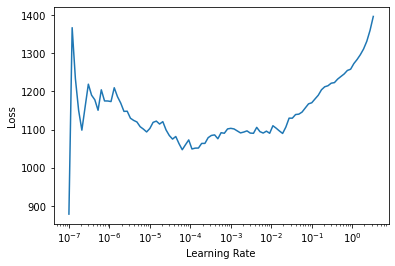

In [48]:
learn.lr_find()

In [49]:
learn.fit_one_cycle(20, max_lr=slice(3e-7, 3e-5), wd=0.1)

epoch,train_loss,valid_loss,laplace_log,time
0,1113.630371,932.020813,-8.250008,00:00
1,1108.780029,930.872070,-8.184747,00:00
2,1083.994385,898.161438,-8.176427,00:00
3,1133.976807,905.426819,-8.317463,00:00
4,1104.743652,892.129578,-8.247717,00:00
5,1095.240845,897.492188,-8.256989,00:00
6,1096.163940,901.494629,-8.282640,00:00
7,1103.163818,885.460938,-8.276800,00:00
8,1102.705444,909.799194,-8.314186,00:00
9,1083.346680,929.901611,-8.267566,00:00


Spent most of afternoon figuring out how to create the test data, feed it through model so that it can be applied to the submission file --> most of it was pandas stuff :)

In [106]:
sub = sample_sub
sub['Patient'] = sub['Patient_Week'].apply(lambda x: x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub = sub[['Patient', 'Weeks', 'Confidence', 'Patient_Week']]

In [107]:
sub.columns, test_df.columns

(Index(['Patient', 'Weeks', 'Confidence', 'Patient_Week'], dtype='object'),
 Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus'], dtype='object'))

In [108]:
testing = sub.merge(test_df.drop('Weeks', axis=1), on='Patient')
testing.head(4)

,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12,3020,70.186855,73,Male,Ex-smoker
1,ID00419637202311204720264,-11,100,ID00419637202311204720264_-11,3020,70.186855,73,Male,Ex-smoker
2,ID00419637202311204720264,-10,100,ID00419637202311204720264_-10,3020,70.186855,73,Male,Ex-smoker
3,ID00419637202311204720264,-9,100,ID00419637202311204720264_-9,3020,70.186855,73,Male,Ex-smoker


In [109]:
test_dl = learn.dls.test_dl(testing)

In [110]:
preds, _ = learn.get_preds(dl=test_dl)
preds

tensor([[1784.9395, 2563.6516, 3549.1936],
        [1784.8574, 2563.5339, 3549.0308],
        [1784.7756, 2563.4167, 3548.8682],
        ...,
        [1727.4865, 2481.1082, 3434.8887],
        [1727.4043, 2480.9905, 3434.7258],
        [1727.3224, 2480.8730, 3434.5635]])

In [111]:
preds.shape, sample_sub.shape

(torch.Size([730, 3]), (730, 5))

In [113]:
#reload submission since we manipulated it
sample_sub = pd.read_csv(path/'sample_submission.csv')
sample_sub.head(1)

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100


In [114]:
sample_sub['FVC'] = preds[:, 1]

In [115]:
(preds[:, 2] - preds[:, 0]).shape

torch.Size([730])

In [116]:
(preds[:, 2] - preds[:, 0]).mean()

tensor(1724.4078)

In [117]:
#yikes

In [118]:
sample_sub['Confidence'] = preds[:, 2] - preds[:, 0]

In [119]:
sample_sub

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2563.651611,1764.254150
1,ID00421637202311550012437_-12,2563.533936,1764.173340
2,ID00422637202311677017371_-12,2563.416748,1764.092529
3,ID00423637202312137826377_-12,2563.299316,1764.011841
4,ID00426637202313170790466_-12,2563.181396,1763.931152
...,...,...,...
725,ID00419637202311204720264_133,2481.343262,1707.564087
726,ID00421637202311550012437_133,2481.225830,1707.483276
727,ID00422637202311677017371_133,2481.108154,1707.402222
728,ID00423637202312137826377_133,2480.990479,1707.321533


The above workflow got an initial day score of -8.1114 which is terrible :) <br>

9 Days to work on it and improve :)<br>

Something is up with the quantile loss function(!) The std deviation (confidence) is MASSIVE - we don't want it to be in the thousands (see cell below).

This is the first thing that needs to be fixed before playing around with model architectures or engineering the data further. If you are not using an appropriate loss function --> the model will be unable to train properly.

In [122]:
preds[0][2] - preds[0][0]

tensor(1764.2542)